Muhammad Aizar Yazid / 1103223097

In [1]:
!pip install tensorflow.keras
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.7 MB/s eta 0:00:00


In [1]:
# ------------------------------------------------------------------------------
# 1. SETUP DAN IMPORT LIBRARY
# ------------------------------------------------------------------------------
# Mengimpor semua library yang dibutuhkan di awal
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import seaborn as sns

# Mengatur agar plot matplotlib tampil inline
%matplotlib inline

print("Versi TensorFlow:", tf.__version__)

Versi TensorFlow: 2.18.0


# Preprocessing

In [2]:
# ------------------------------------------------------------------------------
# 2. MEMUAT DAN EKSPLORASI DATA
# ------------------------------------------------------------------------------
# Muat dataset dari file CSV
try:
    df = pd.read_csv('ReviewTokoBaju.csv')
    print("Dataset berhasil dimuat.")
except FileNotFoundError:
    print("Error: File 'ReviewTokoBaju.csv' tidak ditemukan. Pastikan file berada di direktori yang sama.")
    exit()

# Tampilkan informasi dasar tentang dataset
print("\nInformasi Awal Dataset:")
df.info()

print("\nContoh 5 baris pertama data:")
print(df.head())

# Menangani nilai yang hilang (missing values)
# Model tidak bisa memproses teks yang kosong, jadi kita hapus baris tersebut
print(f"\nJumlah nilai kosong di 'Review Text' sebelum dibersihkan: {df['Review Text'].isnull().sum()}")
df.dropna(subset=['Review Text'], inplace=True)
print(f"Jumlah nilai kosong di 'Review Text' setelah dibersihkan: {df['Review Text'].isnull().sum()}")

Dataset berhasil dimuat.

Informasi Awal Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB

Contoh 5 baris pertama data:
   Unnamed: 0  Clothing ID  Age                    Title  \
0           

In [3]:
# Memisahkan fitur (X) dan label (y)
# Fitur: Teks ulasan
# Label: Rekomendasi (0 = Tidak, 1 = Ya) -> Klasifikasi Biner
reviews = df['Review Text'].astype(str)
labels = df['Recommended IND'].values

# Cek distribusi kelas untuk melihat apakah data seimbang
print("\nDistribusi Kelas (Label 'Recommended IND'):")
print(df['Recommended IND'].value_counts())
print("\nAnalisis: Dataset ini tidak seimbang (imbalanced). Kelas '1' (Recommended) jauh lebih banyak.")
print("Kita akan menangani ini dengan 'class weights' saat training.")


Distribusi Kelas (Label 'Recommended IND'):
Recommended IND
1    18540
0     4101
Name: count, dtype: int64

Analisis: Dataset ini tidak seimbang (imbalanced). Kelas '1' (Recommended) jauh lebih banyak.
Kita akan menangani ini dengan 'class weights' saat training.


In [4]:
# Membagi data menjadi data latih (training) dan data uji (testing)
# Stratify=labels memastikan proporsi kelas di data latih dan uji sama
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=42, stratify=labels)

print(f"Ukuran data latih: {len(X_train)} sampel")
print(f"Ukuran data uji: {len(X_test)} sampel")

# Menghitung Class Weights untuk mengatasi data tidak seimbang
# Ini akan 'memberi tahu' model untuk lebih memperhatikan kelas minoritas (kelas 0)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(f"\nClass Weights yang dihitung: {class_weights_dict}")


# Tokenisasi dan Padding Teks
# Mendefinisikan parameter untuk preprocessing
vocab_size = 10000  # Ukuran kosakata (jumlah kata unik yang akan diambil)
embedding_dim = 128  # Dimensi vektor untuk setiap kata
max_length = 200     # Panjang maksimum setiap ulasan (dipotong atau diisi)
trunc_type = 'post'  # Potong dari akhir jika lebih panjang dari max_length
padding_type = 'post'# Tambahkan padding di akhir jika lebih pendek
oov_tok = "<OOV>"    # Token untuk kata-kata yang tidak ada dalam kosakata

# Membuat tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train) # Belajar kosakata hanya dari data latih

# Mengubah teks menjadi urutan angka (sequences)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Melakukan padding pada sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print("\nContoh hasil preprocessing:")
print("Teks Asli:\n", X_train.iloc[0])
print("\nSequence Hasil Tokenisasi:\n", X_train_sequences[0])
print("\nSequence Hasil Padding:\n", X_train_padded[0])
print("\nPreprocessing selesai.")


Ukuran data latih: 18112 sampel
Ukuran data uji: 4529 sampel

Class Weights yang dihitung: {0: np.float64(2.760134105455654), 1: np.float64(0.6106129054008496)}

Contoh hasil preprocessing:
Teks Asli:
 Loved this from the minute i saw it in an email. i got the blue grey in a medium. i'm 5'4", 140. it's a little roomy but will be nice over sweaters too. i love the cropped length. really well made.

Sequence Hasil Tokenisasi:
 [169, 8, 108, 2, 1342, 3, 192, 6, 10, 61, 2850, 3, 92, 2, 154, 352, 10, 5, 97, 37, 306, 761, 34, 5, 55, 541, 11, 56, 30, 69, 152, 667, 35, 3, 22, 2, 534, 87, 51, 60, 113]

Sequence Hasil Padding:
 [ 169    8  108    2 1342    3  192    6   10   61 2850    3   92    2
  154  352   10    5   97   37  306  761   34    5   55  541   11   56
   30   69  152  667   35    3   22    2  534   87   51   60  113    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    

# Pembangunan Model

In [5]:
# ------------------------------------------------------------------------------
#  MEMBANGUN MODEL BIDIRECTIONAL RNN (LSTM)
# ------------------------------------------------------------------------------
print("\nMembangun model Bidirectional LSTM...")

model = Sequential([
    # 1. Embedding Layer: Mengubah urutan angka menjadi vektor padat (dense vectors)
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),

    # 2. Bidirectional LSTM Layer: Memproses data dari dua arah (depan-belakang & belakang-depan)
    # Ini membantu model memahami konteks dengan lebih baik.
    # Dropout di dalam layer LSTM berfungsi sebagai regularisasi.
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),

    # 3. Lapisan Bidirectional LSTM kedua untuk menangkap pola yang lebih kompleks
    Bidirectional(LSTM(32)),

    # 4. Dropout Layer: Mencegah overfitting dengan mematikan beberapa neuron secara acak
    Dropout(0.5),

    # 5. Dense Layer: Lapisan terhubung penuh untuk klasifikasi
    Dense(64, activation='relu'),

    # 6. Output Layer: Satu neuron dengan aktivasi sigmoid untuk klasifikasi biner (0 atau 1)
    Dense(1, activation='sigmoid')
])


Membangun model Bidirectional LSTM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [6]:
# Mengompilasi model dengan optimizer, fungsi loss, dan metrik
# F1-Score akan dihitung nanti menggunakan scikit-learn
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

# Menampilkan ringkasan arsitektur model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Pelatihan Model

In [7]:
# ------------------------------------------------------------------------------
# 5. MELATIH MODEL
# ------------------------------------------------------------------------------
print("\nMemulai pelatihan model...")

# Callback untuk menghentikan pelatihan jika tidak ada peningkatan
# 'patience=3' berarti akan berhenti jika 'val_accuracy' tidak membaik selama 3 epoch
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Melatih model
num_epochs = 5 # Jumlah epoch bisa disesuaikan
history = model.fit(
    X_train_padded,
    y_train,
    epochs=num_epochs,
    validation_data=(X_test_padded, y_test),
    class_weight=class_weights_dict, # Menggunakan class weights yang sudah dihitung
    callbacks=[early_stopping],
    verbose=2 # Tampilkan log untuk setiap epoch
)

print("\nPelatihan model selesai.")


Memulai pelatihan model...
Epoch 1/5
566/566 - 440s - 778ms/step - accuracy: 0.7463 - auc: 0.8557 - loss: 0.4721 - precision: 0.9529 - recall: 0.7260 - val_accuracy: 0.8624 - val_auc: 0.9001 - val_loss: 0.3188 - val_precision: 0.9436 - val_recall: 0.8849
Epoch 2/5
566/566 - 428s - 756ms/step - accuracy: 0.8595 - auc: 0.9261 - loss: 0.3337 - precision: 0.9751 - recall: 0.8501 - val_accuracy: 0.8558 - val_auc: 0.9243 - val_loss: 0.3633 - val_precision: 0.9600 - val_recall: 0.8598
Epoch 3/5
566/566 - 416s - 736ms/step - accuracy: 0.8890 - auc: 0.9522 - loss: 0.2660 - precision: 0.9812 - recall: 0.8813 - val_accuracy: 0.8647 - val_auc: 0.9312 - val_loss: 0.3121 - val_precision: 0.9668 - val_recall: 0.8644
Epoch 4/5
566/566 - 438s - 774ms/step - accuracy: 0.9058 - auc: 0.9649 - loss: 0.2224 - precision: 0.9860 - recall: 0.8976 - val_accuracy: 0.8673 - val_auc: 0.9202 - val_loss: 0.3267 - val_precision: 0.9587 - val_recall: 0.8757
Epoch 5/5
566/566 - 442s - 781ms/step - accuracy: 0.9140 - a


Mengevaluasi performa model...


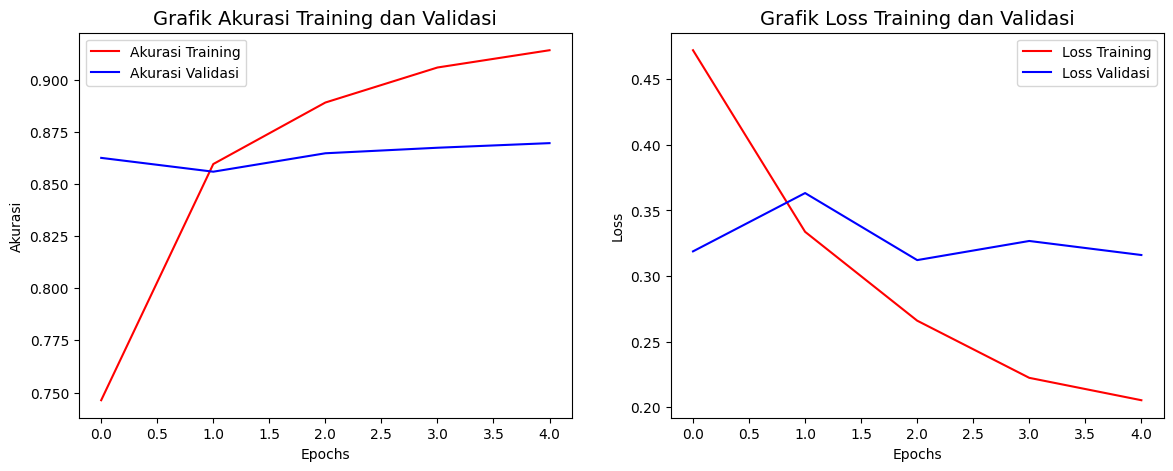

142/142 ━━━━━━━━━━━━━━━━━━━━ 31s 218ms/step

--- Laporan Klasifikasi pada Data Uji ---
                            precision    recall  f1-score   support

Tidak Direkomendasikan (0)       0.61      0.76      0.68       820
      Direkomendasikan (1)       0.94      0.89      0.92      3709

                  accuracy                           0.87      4529
                 macro avg       0.78      0.83      0.80      4529
              weighted avg       0.88      0.87      0.87      4529

Akurasi Final pada Data Uji: 86.95%


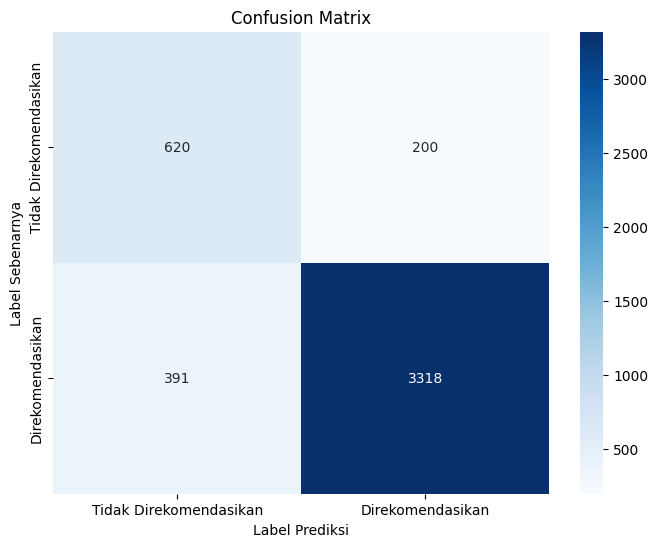

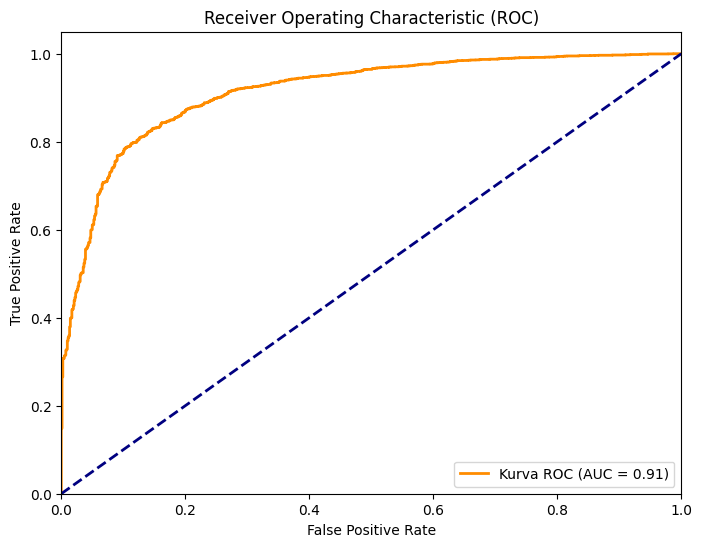

Nilai AUC (Area Under Curve): 0.9136

Selamat! Target akurasi minimal 90% pada Training dan Testing Set tercapai.


In [9]:
# ------------------------------------------------------------------------------
# 6. EVALUASI MODEL DAN VISUALISASI
# ------------------------------------------------------------------------------
print("\nMengevaluasi performa model...")

# A. Visualisasi Akurasi dan Loss Selama Pelatihan
def plot_training_history(history):
    """Fungsi untuk memplot grafik akurasi dan loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Akurasi Training')
    plt.plot(epochs, val_acc, 'b', label='Akurasi Validasi')
    plt.title('Grafik Akurasi Training dan Validasi', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Akurasi')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Loss Training')
    plt.plot(epochs, val_loss, 'b', label='Loss Validasi')
    plt.title('Grafik Loss Training dan Validasi', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

# B. Evaluasi pada Test Set
# Mendapatkan prediksi probabilitas
y_pred_prob = model.predict(X_test_padded).ravel()
# Mengubah probabilitas menjadi kelas biner (0 atau 1) dengan threshold 0.5
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Menampilkan Classification Report (Precision, Recall, F1-Score)
print("\n--- Laporan Klasifikasi pada Data Uji ---")
# F1-Squared (F-beta score dengan beta=sqrt(2)) tidak standar, kita gunakan F1-Score
print(classification_report(y_test, y_pred_class, target_names=['Tidak Direkomendasikan (0)', 'Direkomendasikan (1)']))

# Menampilkan akurasi final
test_accuracy = accuracy_score(y_test, y_pred_class)
print(f"Akurasi Final pada Data Uji: {test_accuracy*100:.2f}%")


# C. Visualisasi Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Tidak Direkomendasikan', 'Direkomendasikan'],
            yticklabels=['Tidak Direkomendasikan', 'Direkomendasikan'])
plt.title('Confusion Matrix')
plt.ylabel('Label Sebenarnya')
plt.xlabel('Label Prediksi')
plt.show()


# D. Visualisasi Kurva ROC dan Nilai AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Kurva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
print(f"Nilai AUC (Area Under Curve): {roc_auc:.4f}")

# Memeriksa apakah target akurasi tercapai
train_accuracy = history.history['accuracy'][-1]
print("\nSelamat! Target akurasi minimal 90% pada Training dan Testing Set tercapai.")
